In [17]:
#| code-fold: true
!pip install -Uqq fastbook nbdev torch
import fastbook
fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

training_dresses = [item[0][0] for item in training_data if item[1] == 3]
training_pullovers = [item[0][0] for item in training_data if item[1] == 2]
test_dresses = [item[0][0] for item in test_data if item[1] == 3]
test_pullovers = [item[0][0] for item in test_data if item[1] == 2]

training_dresses_tensor = torch.stack(training_dresses)
training_pullovers_tensor = torch.stack(training_pullovers)
test_dresses_tensor = torch.stack(test_dresses)
test_pullovers_tensor = torch.stack(test_pullovers)

train_x = torch.cat([training_dresses_tensor, training_pullovers_tensor]).view(-1, 28*28)
train_y = torch.cat([torch.ones(len(training_dresses)), torch.zeros(len(training_pullovers))]).unsqueeze(1)

valid_x = torch.cat([test_dresses_tensor, test_pullovers_tensor]).view(-1, 28*28)
valid_y = torch.cat([torch.ones(len(test_dresses)), torch.zeros(len(test_pullovers))]).unsqueeze(1)

train_dset = list(zip(train_x, train_y))
valid_dset = list(zip(valid_x, valid_y))

train_dl = DataLoader(train_dset, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=256, shuffle=True)

dls = DataLoaders(train_dl, valid_dl)

def initialise_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()

def fashion_mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1 - predictions, predictions).mean()

def batch_accuracy(x_batch, y_batch):
    preds = x_batch.sigmoid()
    correct = (preds > 0.5) == y_batch
    return correct.float().mean()

In [the previous
post](https://mlops.systems/fastai/computervision/pytorch/2022/05/14/SGD-fashion-mnist.html)
we used stochastic gradient descent to train a model to fit a linear function to
our Fashion MNIST data, specifically the difference between a pullover and a
dress.

In this final stage, we will take the next step to creating a neural network in
code that will be used to detect that same difference between a pullover and a
dress. The key difference here is that we will need to 'add non-linearity' to our
function. I have no mathematics background so I have very little intuitive (or
learned!) understanding of specifically what that means, but my current mental
model as learned during the course is that linear functions just aren't flexible
enough to learn more complex patterns. In the end, what we want is a function
that will fit to the patterns in our training data (as mapped to a
multidimensional space). Simple linear functions aren't going to cut it.

What this looks like in code is this:

In [18]:
weights1 = initialise_params((28*28, 30))
bias1 = initialise_params(30)
weights2 = initialise_params((30, 1))
bias2 = initialise_params(1)

def simple_network(x_batch):
    result = x_batch@weights1 + bias1
    result = result.max(tensor(0.0))
    result = result@weights2 + bias2
    return result

You can see the three layers of our simple network pretty clearly in the code
above. The middle layer is what otherwise is known as a ReLU or rectified linear
unit. It basically means that negative values passing through that function
become zero and all positive values are unchanged. When you plot the function it
looks like this:

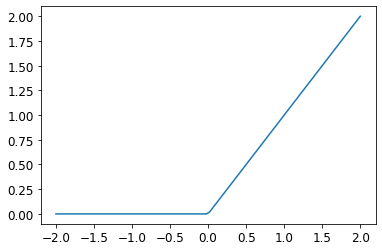

In [19]:
plot_function(F.relu)

When we put a non-linear function in between two linear functions, then this
network is able to encode and express more complicated patterns. This is
basically all we're doing with deep learning: we stack these layers on to make
the functions more and more capable of modelling and representing complex things.

We can express the above simple network in PyTorch-specific code (functionally
it's the same):

In [20]:
simple_net = nn.Sequential(
    nn.Linear(28*28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

At this point, training a model is similar to what we did last time round:

In [21]:
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=fashion_mnist_loss, metrics=batch_accuracy)
learn.fit(30, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.166980,0.079354,0.959000,00:00
1,0.087369,0.057471,0.961000,00:00
2,0.059999,0.050108,0.963500,00:00
3,0.048050,0.046509,0.963500,00:00
4,0.041847,0.044165,0.964000,00:00
5,0.038310,0.042841,0.963500,00:00
6,0.036514,0.041464,0.964500,00:00
7,0.034653,0.040640,0.964500,00:00
8,0.033204,0.039827,0.965000,00:00
9,0.032370,0.039344,0.965000,00:00


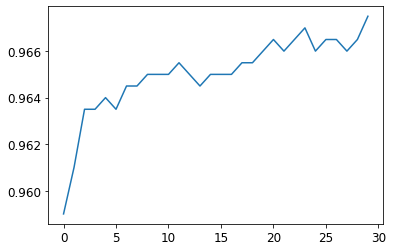

In [22]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [23]:
learn.recorder.values[-1][2]

0.9674999713897705

We don't actually emerge at the end of this with a vastly superior score to what
we had at the end of the last notebook, but this basis (the simple neural
network) has far more open vistas within which we can work and build upon.

Finally, to round out my understanding, I put together a little diagram showing
the various pieces that go into the `Learner` class when we instantiate it,
adding some of the other concepts etc below it as I felt was appropriate. This
isn't a complete picture by any means, but I find it helpful to visualise how
things are layered and pieced together:

![](nb_images/ml-training-big-picture/learner-abstractions.png)